In [1]:
import os
import sys

# Set Java 17 home for PySpark
os.environ['JAVA_HOME'] = '/opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home'
os.environ['PATH'] = f"/opt/homebrew/opt/openjdk@17/bin:{os.environ['PATH']}"

# Fix for XGBoost
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/opt/libomp/lib:' + os.environ.get('DYLD_LIBRARY_PATH', '')

print("✅ Java 17 environment set")
print(f"JAVA_HOME: {os.environ.get('JAVA_HOME')}")

✅ Java 17 environment set
JAVA_HOME: /opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home


In [2]:
import os
os.environ['JAVA_HOME'] = '/opt/homebrew/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home'

# Clear any existing Spark context
from pyspark.sql import SparkSession
import pyspark

# Force stop any existing Spark context
try:
    spark.stop()
except:
    pass

try:
    sc.stop()
except:
    pass

# Set Spark configuration to avoid port binding issues
os.environ['PYSPARK_SUBMIT_ARGS'] = '--driver-memory 2g pyspark-shell'
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'

# Create new Spark session with explicit configuration
spark = (SparkSession.builder
    .appName("ML_Pipeline")
    .master("local[1]")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
    .getOrCreate())

print("Spark session created successfully!")
print(f"Spark version: {spark.version}")

# Test simple operation
df = spark.range(10)
print(f"DataFrame count: {df.count()}")
print("Spark is working correctly!")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/26 02:51:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session created successfully!
Spark version: 4.0.1
DataFrame count: 10
Spark is working correctly!


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, date_format
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import joblib
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Setup

In [4]:
# Start Spark
spark = SparkSession.builder \
    .appName("setup") \
    .master("local[*]") \
    .getOrCreate()

# Load gold layer
features = spark.read.parquet("data/gold/feature_store")
labels   = spark.read.parquet("data/gold/label_store")

# Construct loan_id in features
features = features.withColumn(
    "loan_id",
    concat_ws("_", col("Customer_ID"), date_format(col("feature_snapshot_date"), "yyyy_MM_dd"))
)

# Join labels
labeled_df = features.join(
    labels.select("loan_id", "label"),
    on="loan_id",
    how="left"
)

# Filter labeled only
combined_labeled = labeled_df.filter(col("label").isNotNull())

# Save to datamart
combined_labeled.write.mode("overwrite").parquet("data/gold/combined_labeled.parquet")

print("Setup complete: combined_labeled.parquet written.")

25/10/26 02:52:20 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/10/26 02:52:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Setup complete: combined_labeled.parquet written.


In [5]:
combined_labeled.show()

+--------------------+-----------+---------------------+-----------------+---------------+-------------+-------------------+----------------------+--------------------+--------------------+------------------------+------------------+---------------------+--------------+------------------+--------------------+--------------------+--------------------+-----------------------+--------------------+--------------------+--------------+---------------------+-------------------------+---------------+-------------+------+------+-----+-----+-----+------+------+-----+------+------+-----+------+-----+-----+------+------+------+-----+------+-----+-----+
|             loan_id|Customer_ID|feature_snapshot_date|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Utilization_Ratio|   Monthly_Balance|credit_history_months|num_loan_types| log_Annual_Income|      debt_to_income|       emi_to_salary|     investment_rate

### Logistic Regression

In [6]:
# Load prepared labeled dataset
df = spark.read.parquet("data/gold/combined_labeled.parquet")

# Assemble and scale features
non_features = ['Customer_ID', 'feature_snapshot_date', 'loan_id', 'label']
vec_cols = [c for c in df.columns if c.endswith("_vec")]
feature_cols = [c for c in df.columns if c not in non_features + vec_cols]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
assembled = assembler.transform(df)

scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled)
scaled = scaler_model.transform(assembled)

# Split by time
train_df = scaled.filter((col("feature_snapshot_date") >= "2023-01-01") & (col("feature_snapshot_date") <= "2023-12-01"))
val_df   = scaled.filter(col("feature_snapshot_date") == "2024-01-01")
test_df  = scaled.filter(col("feature_snapshot_date") == "2024-02-01")

# Train logistic regression
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100)
lr_model = lr.fit(train_df)

# Evaluation function
def evaluate_model(predictions):
    evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="probability", metricName="areaUnderROC")
    auc = evaluator.evaluate(predictions)

    preds = predictions.withColumn("correct", when(col("prediction") == col("label"), 1).otherwise(0))
    total = preds.count()
    correct = preds.filter(col("correct") == 1).count()
    tp = preds.filter((col("prediction") == 1) & (col("label") == 1)).count()
    fp = preds.filter((col("prediction") == 1) & (col("label") == 0)).count()
    fn = preds.filter((col("prediction") == 0) & (col("label") == 1)).count()

    accuracy = correct / total if total > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "AUC": round(auc, 4),
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4)
    }

# Create folder for metrics
metrics_dir = "model_store/logreg_metrics"
os.makedirs(metrics_dir, exist_ok=True)

# Evaluate on splits
for name, split in [("train", train_df), ("validation", val_df), ("test", test_df)]:
    pred = lr_model.transform(split)
    metrics = evaluate_model(pred)
    print(f"\n=== {name.capitalize()} Metrics ===")
    print(metrics)
    
    # Save to corresponding JSON
    metrics_path = os.path.join(metrics_dir, f"logreg_{name}.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=2)
    print(f"{name.capitalize()} metrics saved to {metrics_path}")

# Save model (if needed later in selection step)
model_path = "model_store/logistic_model"
if os.path.exists(model_path):
    import shutil
    shutil.rmtree(model_path)
lr_model.save(model_path)
print("\nLogistic regression model saved.")

25/10/26 02:52:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS



=== Train Metrics ===
{'AUC': 0.7939, 'Accuracy': 0.7835, 'Precision': 0.6771, 'Recall': 0.449, 'F1 Score': 0.5399}
Train metrics saved to model_store/logreg_metrics/logreg_train.json

=== Validation Metrics ===
{'AUC': 0.7696, 'Accuracy': 0.7629, 'Precision': 0.6495, 'Recall': 0.4375, 'F1 Score': 0.5228}
Validation metrics saved to model_store/logreg_metrics/logreg_validation.json

=== Test Metrics ===
{'AUC': 0.7798, 'Accuracy': 0.7741, 'Precision': 0.6172, 'Recall': 0.5374, 'F1 Score': 0.5745}
Test metrics saved to model_store/logreg_metrics/logreg_test.json

Logistic regression model saved.


Creating logistic regression visualizations...


<Figure size 1200x600 with 0 Axes>

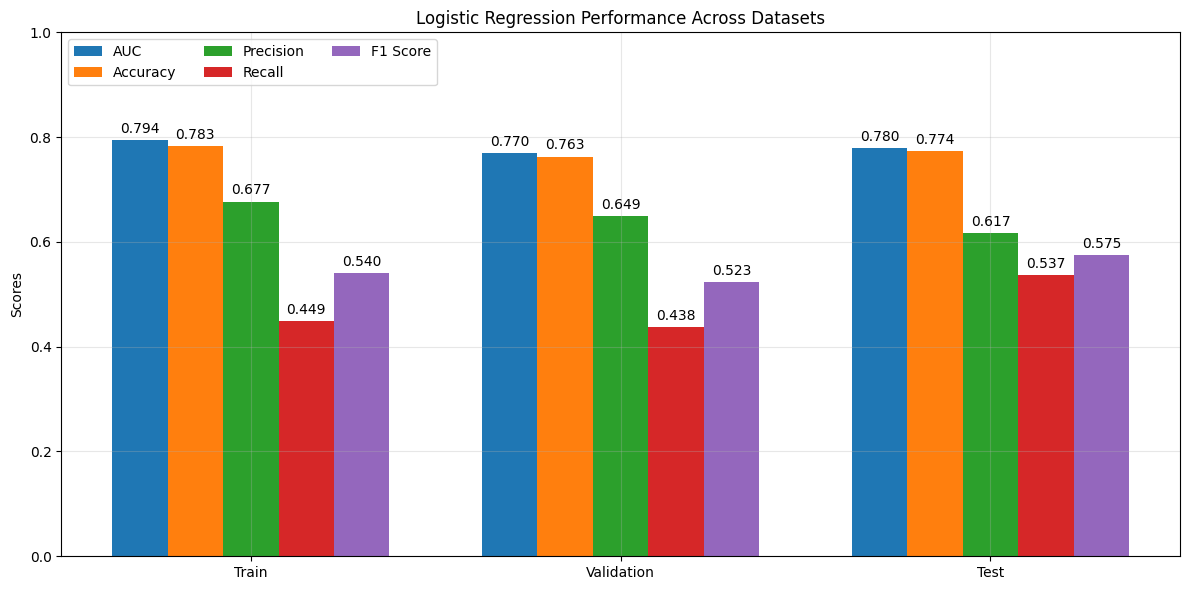

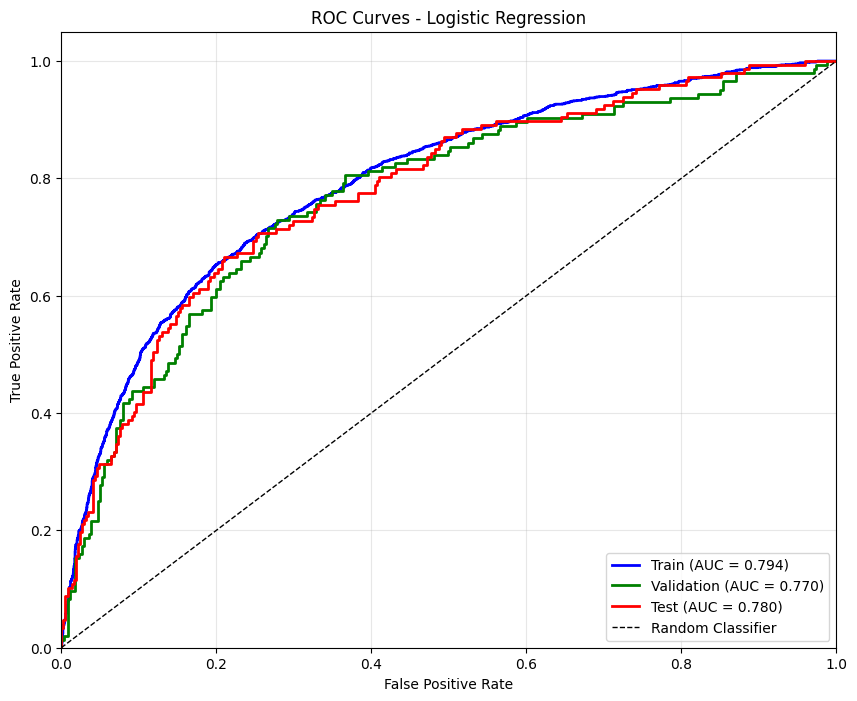

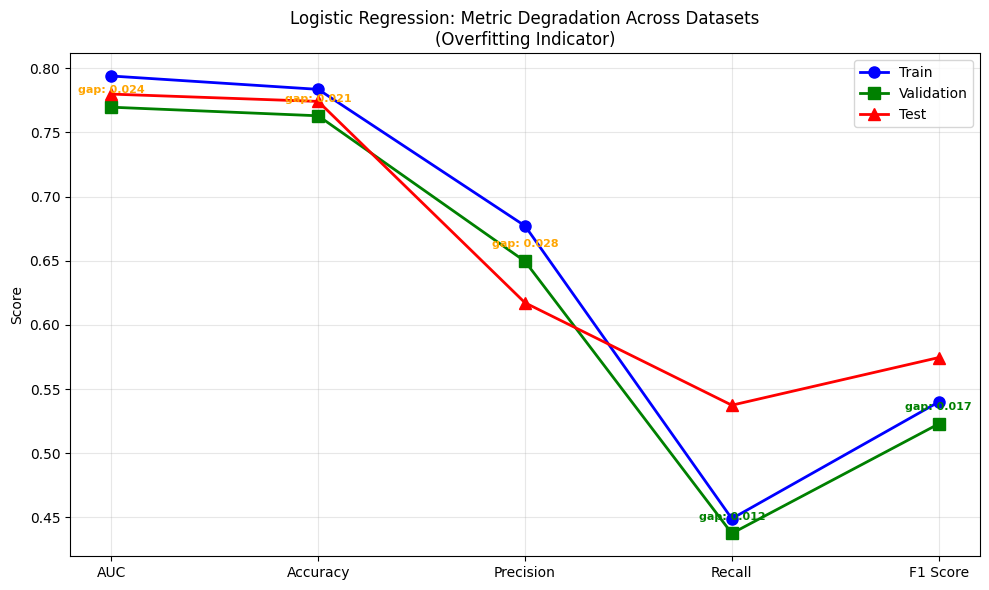

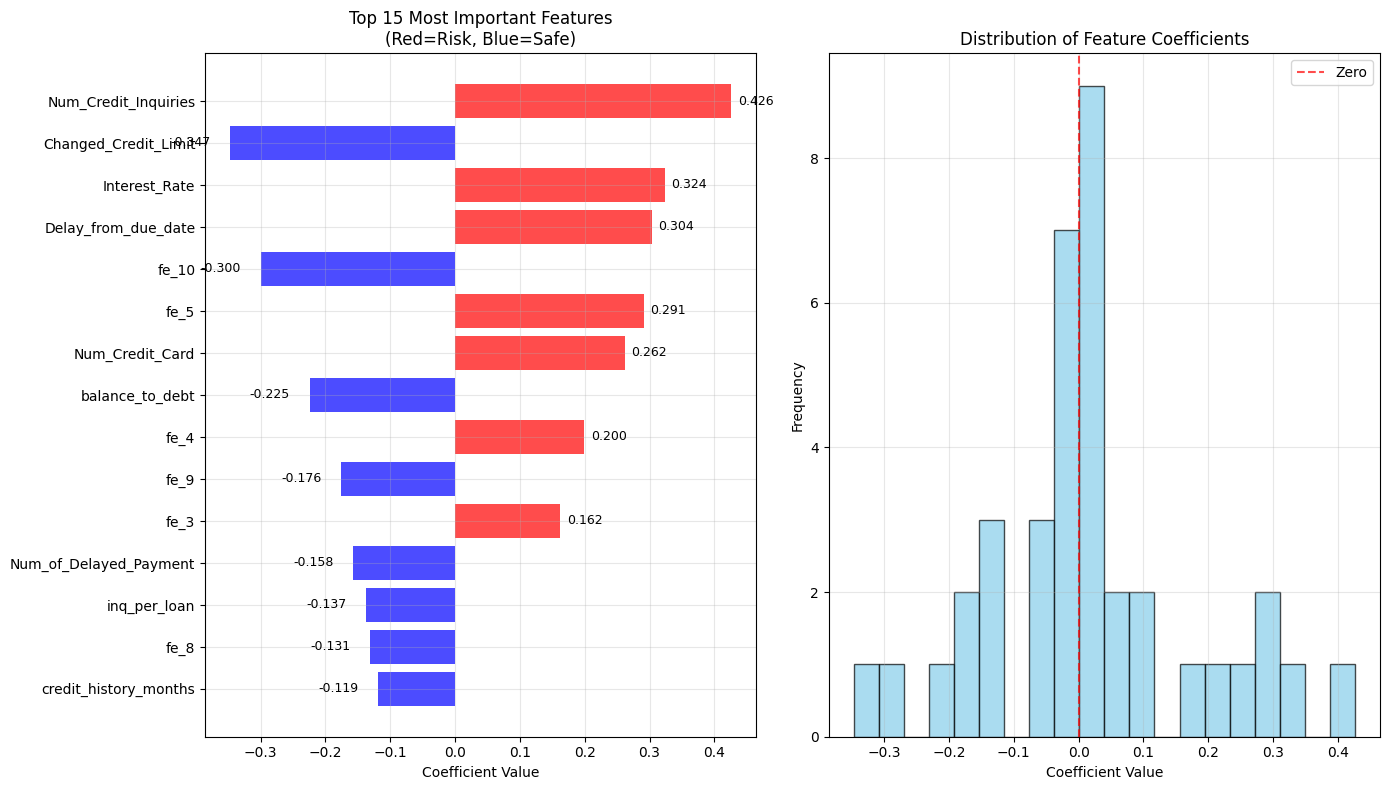


OVERFITTING ANALYSIS
Train AUC: 0.7939
Validation AUC: 0.7696
Test AUC: 0.7798

Train-Validation gap: 0.0243
Validation-Test gap: -0.0102
🟡 Moderate overfitting
✅ Model shows consistent performance

All visualizations saved to model_store/logreg_metrics/


In [7]:
# VISUALIZATION 1: Logistic Regression Performance Across Datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve
import pandas as pd

print("Creating logistic regression visualizations...")

# Get metrics from your existing results
metrics_data = {}
for name in ["train", "validation", "test"]:
    try:
        with open(f"model_store/logreg_metrics/logreg_{name}.json", "r") as f:
            metrics_data[name] = json.load(f)
    except:
        print(f"Could not load metrics for {name}")

# Create performance comparison plot
plt.figure(figsize=(12, 6))
metrics_to_plot = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
dataset_names = ['Train', 'Validation', 'Test']
dataset_keys = ['train', 'validation', 'test']

# Prepare data for plotting
metric_values = {}
for metric in metrics_to_plot:
    metric_values[metric] = []
    for dataset in dataset_keys:
        if dataset in metrics_data:
            metric_values[metric].append(metrics_data[dataset].get(metric, 0))
        else:
            metric_values[metric].append(0)

x = np.arange(len(dataset_names))
width = 0.15
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 6))
for metric, values in metric_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=metric)
    ax.bar_label(rects, padding=3, fmt='%.3f')
    multiplier += 1

ax.set_ylabel('Scores')
ax.set_title('Logistic Regression Performance Across Datasets')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(dataset_names)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_store/logreg_metrics/performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# VISUALIZATION 2: ROC Curves for Logistic Regression
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']

for i, (name, display_name) in enumerate(zip(dataset_keys, dataset_names)):
    try:
        # Get predictions for this dataset
        if name == "train":
            pred_df = lr_model.transform(train_df)
        elif name == "validation":
            pred_df = lr_model.transform(val_df)
        else:  # test
            pred_df = lr_model.transform(test_df)
        
        # Convert to Pandas for ROC calculation
        pred_pdf = pred_df.select("label", "probability").toPandas()
        y_true = pred_pdf["label"].values
        y_prob = pred_pdf["probability"].apply(lambda x: float(x[1])).values  # Probability of class 1
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc_score = metrics_data[name]['AUC']
        
        plt.plot(fpr, tpr, color=colors[i], linewidth=2, 
                 label=f'{display_name} (AUC = {auc_score:.3f})')
        
    except Exception as e:
        print(f"Error creating ROC curve for {name}: {e}")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('model_store/logreg_metrics/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# VISUALIZATION 3: Metric Degradation (Overfitting Indicator)
plt.figure(figsize=(10, 6))

# Prepare data for degradation plot
metrics_detailed = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
train_metrics = [metrics_data['train'].get(m, 0) for m in metrics_detailed]
val_metrics = [metrics_data['validation'].get(m, 0) for m in metrics_detailed]
test_metrics = [metrics_data['test'].get(m, 0) for m in metrics_detailed]

x = np.arange(len(metrics_detailed))
plt.plot(x, train_metrics, 'o-', linewidth=2, markersize=8, label='Train', color='blue')
plt.plot(x, val_metrics, 's-', linewidth=2, markersize=8, label='Validation', color='green')
plt.plot(x, test_metrics, '^-', linewidth=2, markersize=8, label='Test', color='red')

plt.xticks(x, metrics_detailed)
plt.ylabel('Score')
plt.title('Logistic Regression: Metric Degradation Across Datasets\n(Overfitting Indicator)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add gap annotations with color coding
for i, metric in enumerate(metrics_detailed):
    gap = train_metrics[i] - val_metrics[i]
    color = 'red' if gap > 0.05 else 'orange' if gap > 0.02 else 'green'
    plt.annotate(f'gap: {gap:.3f}', (i, val_metrics[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', 
                 fontsize=8, color=color, fontweight='bold')

plt.tight_layout()
plt.savefig('model_store/logreg_metrics/metric_degradation.png', dpi=300, bbox_inches='tight')
plt.show()

# VISUALIZATION 4: Coefficient Analysis (Feature Importance)
plt.figure(figsize=(14, 8))

# Get coefficients from the trained model
coefficients = lr_model.coefficients.toArray()

if len(coefficients) == len(feature_cols):
    # Get top 15 features by absolute coefficient value
    indices = np.argsort(np.abs(coefficients))[::-1][:15]
    top_features = [feature_cols[i] for i in indices]
    top_coefficients = coefficients[indices]
    
    # Create subplots
    plt.subplot(1, 2, 1)
    colors = ['red' if coef > 0 else 'blue' for coef in top_coefficients]
    
    bars = plt.barh(range(len(top_features)), top_coefficients, color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Coefficient Value')
    plt.title('Top 15 Most Important Features\n(Red=Risk, Blue=Safe)')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    
    # Add coefficient values
    for i, (coef, feature) in enumerate(zip(top_coefficients, top_features)):
        plt.text(coef + (0.01 if coef >= 0 else -0.03), i, f'{coef:.3f}', 
                ha='left' if coef >= 0 else 'right', va='center', fontsize=9)
    
    # Subplot 2: Coefficient distribution
    plt.subplot(1, 2, 2)
    plt.hist(coefficients, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Feature Coefficients')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_store/logreg_metrics/coefficient_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print overfitting analysis
print("\n" + "="*50)
print("OVERFITTING ANALYSIS")
print("="*50)

train_auc = metrics_data['train']['AUC']
val_auc = metrics_data['validation']['AUC']
test_auc = metrics_data['test']['AUC']

print(f"Train AUC: {train_auc:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

train_val_gap = train_auc - val_auc
val_test_gap = val_auc - test_auc

print(f"\nTrain-Validation gap: {train_val_gap:.4f}")
print(f"Validation-Test gap: {val_test_gap:.4f}")

if train_val_gap > 0.05:
    print("🔴 Significant overfitting detected")
elif train_val_gap > 0.02:
    print("🟡 Moderate overfitting")
else:
    print("🟢 Good generalization")

if val_test_gap < 0.02:
    print("✅ Model shows consistent performance")
else:
    print("⚠️  Some performance inconsistency detected")

print(f"\nAll visualizations saved to model_store/logreg_metrics/")

### XGBoost

Configuring XGBoost model training...
Hyperparameter search configuration:
Search space combinations: 207,360
Random search iterations: 20
Cross-validation folds: 3
Optimization metric: ROC-AUC
Starting hyperparameter search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best hyperparameters found:
  subsample: 0.6
  reg_lambda: 2
  reg_alpha: 0.1
  n_estimators: 150
  min_child_weight: 7
  max_depth: 3
  learning_rate: 0.1
  gamma: 0
  colsample_bytree: 0.7
Best cross-validation AUC: 0.8071

Creating hyperparameter search visualization...


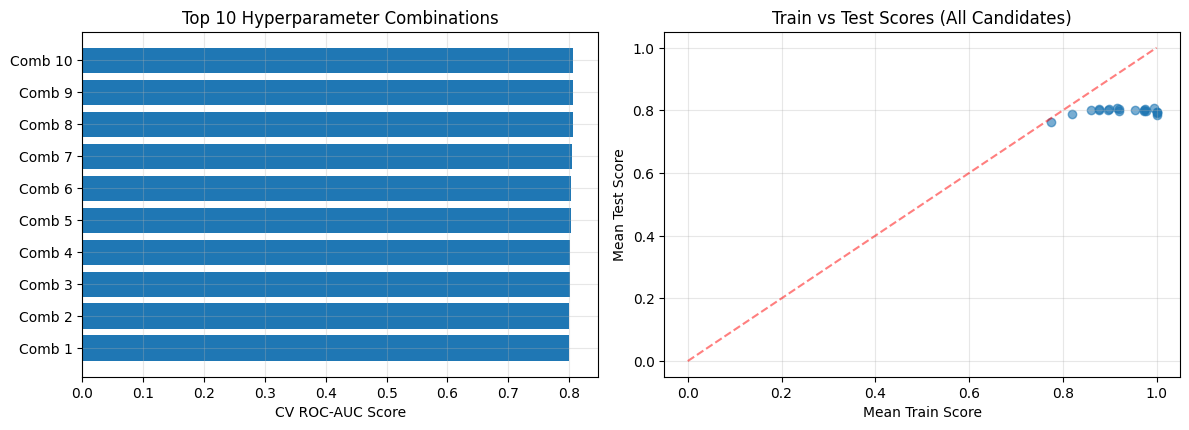

Validation AUC with best model: 0.8285

Comparison with simple tuning:
Simple tuning (n_estimators=100) Validation AUC: 0.8117
Improvement with comprehensive tuning: 0.0168


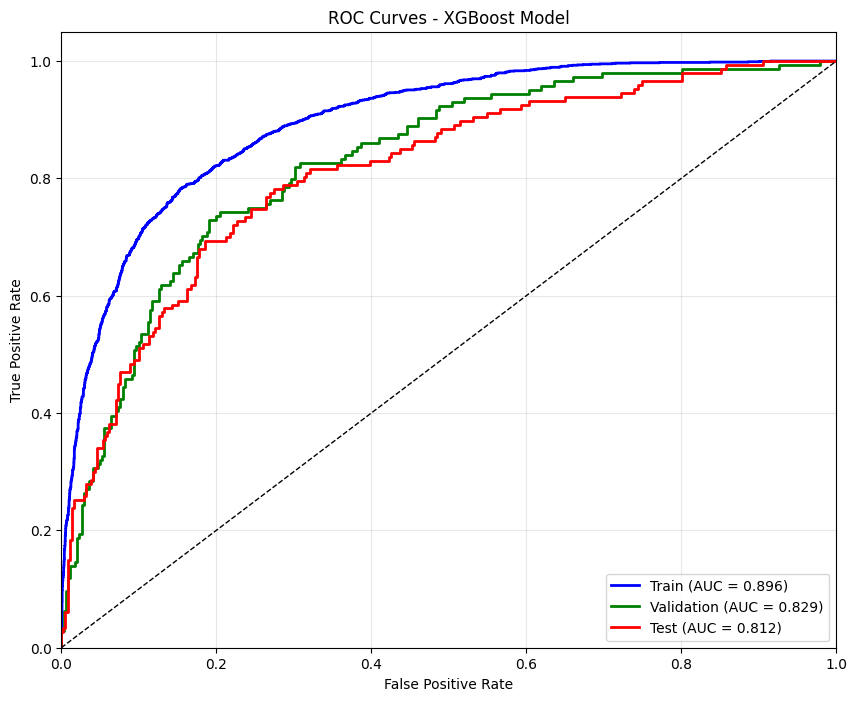

<Figure size 1200x600 with 0 Axes>

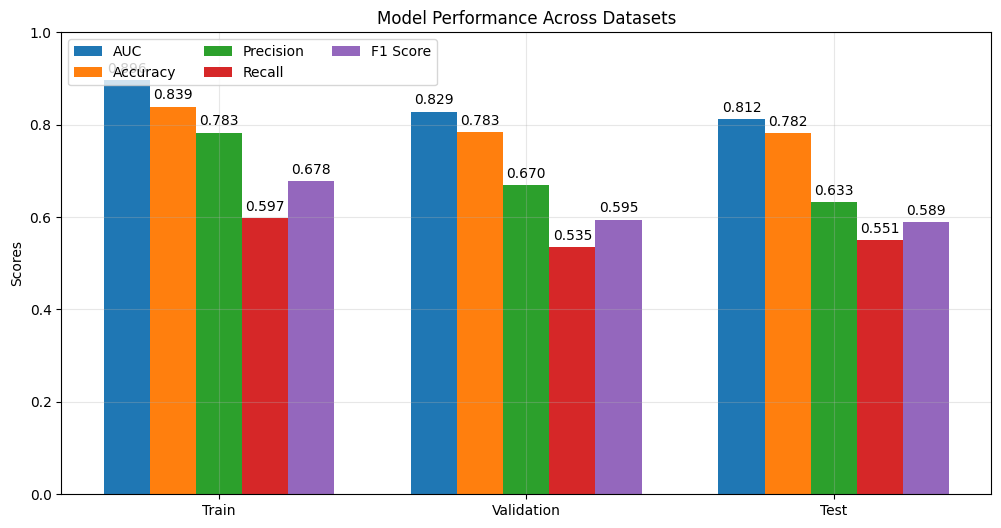

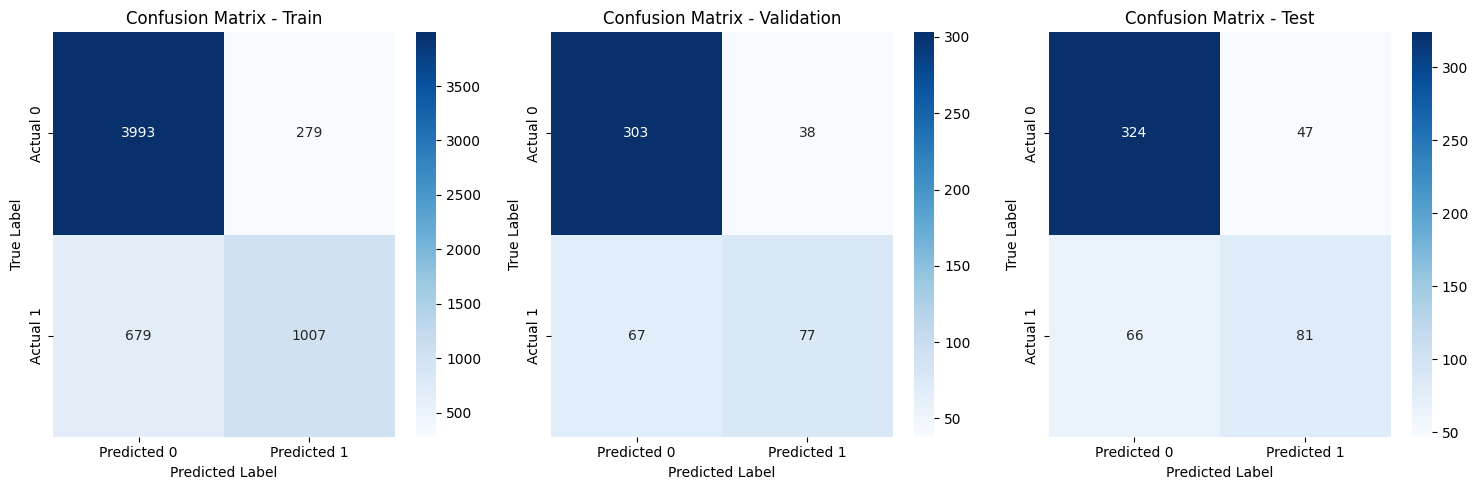


=== Train Metrics ===
{'AUC': 0.8957, 'Accuracy': 0.8392, 'Precision': 0.783, 'Recall': 0.5973, 'F1 Score': 0.6777}
Train metrics saved to model_store/xgboost_metrics/xgboost_train.json

=== Val Metrics ===
{'AUC': 0.8285, 'Accuracy': 0.7835, 'Precision': 0.6696, 'Recall': 0.5347, 'F1 Score': 0.5946}
Val metrics saved to model_store/xgboost_metrics/xgboost_val.json

=== Test Metrics ===
{'AUC': 0.8122, 'Accuracy': 0.7819, 'Precision': 0.6328, 'Recall': 0.551, 'F1 Score': 0.5891}
Test metrics saved to model_store/xgboost_metrics/xgboost_test.json
Best parameters saved to model_store/xgboost_metrics/xgboost_best_params.json
XGBoost model saved to model_store/xgboost_model.pkl

Overfitting Analysis:
Train AUC: 0.8957
Val AUC: 0.8285
Test AUC: 0.8122
Potential overfitting: Train-Val gap = 0.0672

All visualizations saved to model_store/xgboost_metrics/


In [8]:
# Helper: convert Spark DataFrame to NumPy
def spark_df_to_numpy(df):
    pdf = df.select("features", "label").toPandas()
    X = np.vstack(pdf["features"].values)
    y = pdf["label"].values
    return X, y

X_train, y_train = spark_df_to_numpy(train_df)
X_val, y_val     = spark_df_to_numpy(val_df)
X_test, y_test   = spark_df_to_numpy(test_df)

# Helper: evaluation
def evaluate_model(y_true, y_pred, y_prob):
    return {
        "AUC":       round(roc_auc_score(y_true, y_prob), 4),
        "Accuracy":  round(accuracy_score(y_true, y_pred), 4),
        "Precision": round(precision_score(y_true, y_pred), 4),
        "Recall":    round(recall_score(y_true, y_pred), 4),
        "F1 Score":  round(f1_score(y_true, y_pred), 4)
    }

# Enhanced Hyperparameter tuning with RandomizedSearchCV
print("Configuring XGBoost model training...")

# Define comprehensive hyperparameter search space
hyperparameter_space = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2, 3, 4, 5, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

# Configure RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix, precision_recall_curve


random_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        eval_metric='logloss', 
        random_state=42,
        n_jobs=-1
    ),
    param_distributions=hyperparameter_space,
    n_iter=20,  # Number of parameter combinations to try
    cv=3,       # 3-fold cross-validation
    scoring='roc_auc',
    verbose=1,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

print(f"Hyperparameter search configuration:")
print(f"Search space combinations: {np.prod([len(v) for v in hyperparameter_space.values()]):,}")
print(f"Random search iterations: {20}")
print(f"Cross-validation folds: {3}")
print(f"Optimization metric: ROC-AUC")

# Perform hyperparameter search
print("Starting hyperparameter search...")
random_search.fit(X_train, y_train)

# Get the best model from randomized search
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_cv_score = random_search.best_score_

print(f"\nBest hyperparameters found:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"Best cross-validation AUC: {best_cv_score:.4f}")

# VISUALIZATION 1: Hyperparameter Search Results
print("\nCreating hyperparameter search visualization...")
cv_results = random_search.cv_results_

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
# Plot top 10 parameter combinations by mean test score
top_indices = np.argsort(cv_results['mean_test_score'])[-10:]
top_scores = cv_results['mean_test_score'][top_indices]
plt.barh(range(10), top_scores)
plt.yticks(range(10), [f'Comb {i+1}' for i in range(10)])
plt.xlabel('CV ROC-AUC Score')
plt.title('Top 10 Hyperparameter Combinations')
plt.grid(True, alpha=0.3)

# VISUALIZATION 2: Train vs Test scores for all candidates
plt.subplot(2, 2, 2)
plt.scatter(cv_results['mean_train_score'], cv_results['mean_test_score'], alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)
plt.xlabel('Mean Train Score')
plt.ylabel('Mean Test Score')
plt.title('Train vs Test Scores (All Candidates)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_store/xgboost_metrics/hyperparameter_search_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Evaluate best model on validation set
y_val_prob = best_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_val_prob)
print(f"Validation AUC with best model: {val_auc:.4f}")

# Compare with simple n_estimators tuning (your original approach)
print("\nComparison with simple tuning:")
simple_model = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
simple_model.fit(X_train, y_train)
y_val_simple_prob = simple_model.predict_proba(X_val)[:, 1]
simple_auc = roc_auc_score(y_val, y_val_simple_prob)
print(f"Simple tuning (n_estimators=100) Validation AUC: {simple_auc:.4f}")
print(f"Improvement with comprehensive tuning: {val_auc - simple_auc:.4f}")

# Evaluate on all sets with best model
results = {}
predictions = {}

for name, X, y in [("train", X_train, y_train), ("val", X_val, y_val), ("test", X_test, y_test)]:
    y_pred = best_model.predict(X)
    y_prob = best_model.predict_proba(X)[:, 1]
    results[name] = evaluate_model(y, y_pred, y_prob)
    predictions[name] = (y, y_pred, y_prob)

# VISUALIZATION 3: ROC Curves for all datasets
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red']
dataset_names = ['train', 'val', 'test']
display_names = ['Train', 'Validation', 'Test']

for i, name in enumerate(dataset_names):
    y_true, _, y_prob = predictions[name]
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = results[name]['AUC']
    plt.plot(fpr, tpr, color=colors[i], linewidth=2, 
             label=f'{display_names[i]} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - XGBoost Model')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('model_store/xgboost_metrics/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# VISUALIZATION 4: Performance Metrics Comparison
plt.figure(figsize=(12, 6))
metrics_to_plot = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
# Use the actual keys from your results dictionary
dataset_keys = ['train', 'val', 'test']
dataset_display_names = ['Train', 'Validation', 'Test']

metric_values = {metric: [results[name][metric] for name in dataset_keys] 
                for metric in metrics_to_plot}

x = np.arange(len(dataset_display_names))
width = 0.15
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 6))
for metric, values in metric_values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=metric)
    ax.bar_label(rects, padding=3, fmt='%.3f')
    multiplier += 1

ax.set_ylabel('Scores')
ax.set_title('Model Performance Across Datasets')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(dataset_display_names)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.savefig('model_store/xgboost_metrics/performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# VISUALIZATION 5: Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, name in enumerate(dataset_keys):
    y_true, y_pred, _ = predictions[name]
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    axes[idx].set_title(f'Confusion Matrix - {dataset_display_names[idx]}')
    axes[idx].set_xlabel('Predicted Label')
    axes[idx].set_ylabel('True Label')

plt.tight_layout()
plt.savefig('model_store/xgboost_metrics/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Print & save metrics
metrics_dir = "model_store/xgboost_metrics"
os.makedirs(metrics_dir, exist_ok=True)

for name, metrics in results.items():
    print(f"\n=== {name.capitalize()} Metrics ===")
    print(metrics)

    metrics_path = os.path.join(metrics_dir, f"xgboost_{name}.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=2)
    print(f"{name.capitalize()} metrics saved to {metrics_path}")

# Save best parameters and model
best_params_path = os.path.join(metrics_dir, "xgboost_best_params.json")
with open(best_params_path, "w") as f:
    json.dump(best_params, f, indent=2)
print(f"Best parameters saved to {best_params_path}")

# Save model
os.makedirs("model_store", exist_ok=True)
joblib.dump(best_model, "model_store/xgboost_model.pkl")
print("XGBoost model saved to model_store/xgboost_model.pkl")

# Check for overfitting
print("\nOverfitting Analysis:")
train_auc = results["train"]["AUC"]
val_auc = results["val"]["AUC"]
test_auc = results["test"]["AUC"]

print(f"Train AUC: {train_auc:.4f}")
print(f"Val AUC: {val_auc:.4f}") 
print(f"Test AUC: {test_auc:.4f}")

train_val_gap = train_auc - val_auc
if train_val_gap > 0.05:
    print(f"Potential overfitting: Train-Val gap = {train_val_gap:.4f}")
elif train_val_gap > 0.02:
    print(f"Moderate gap: Train-Val gap = {train_val_gap:.4f}")
else:
    print(f"Good generalization: Train-Val gap = {train_val_gap:.4f}")

print(f"\nAll visualizations saved to model_store/xgboost_metrics/")

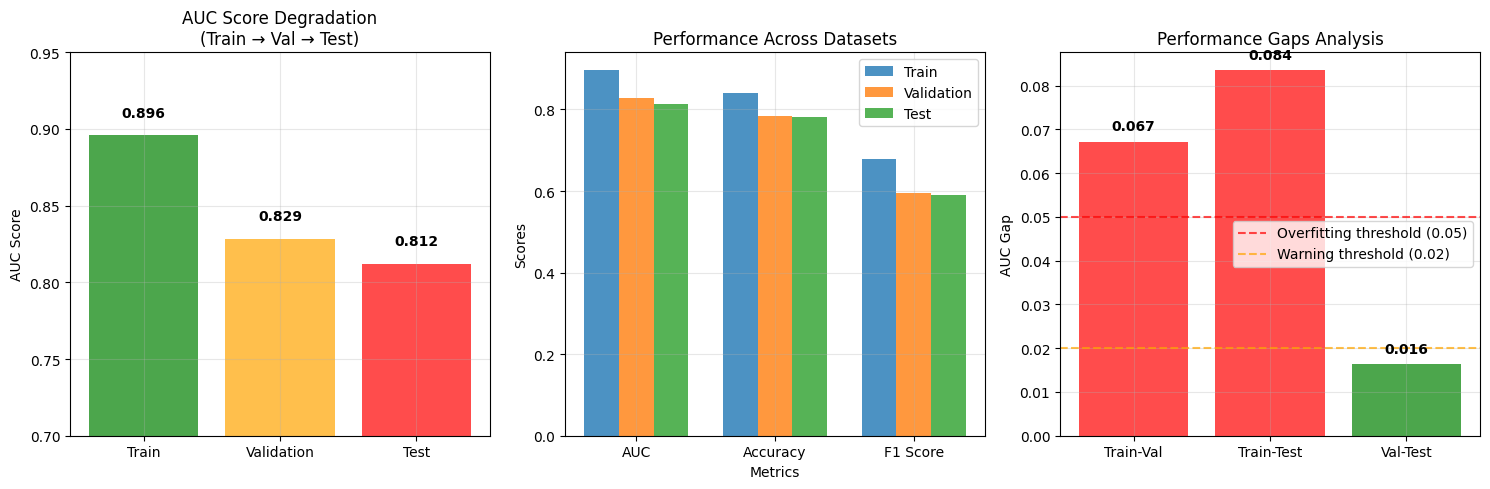

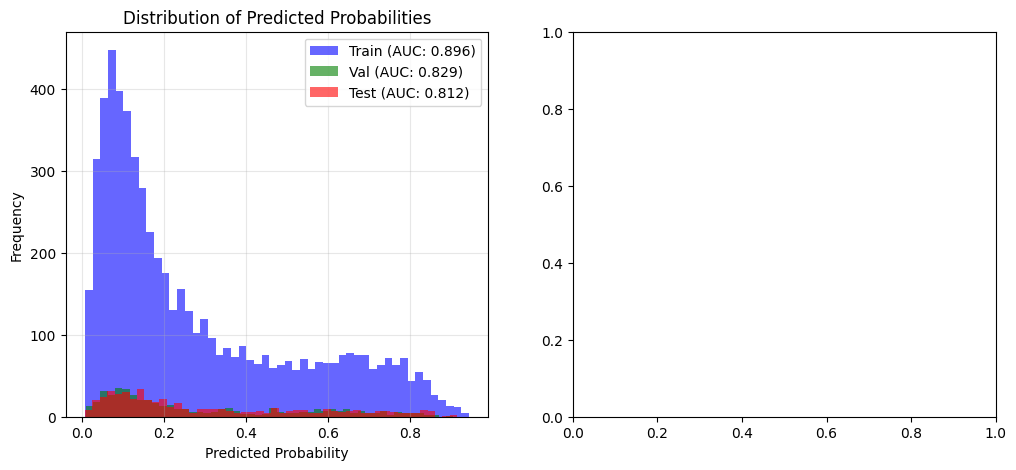

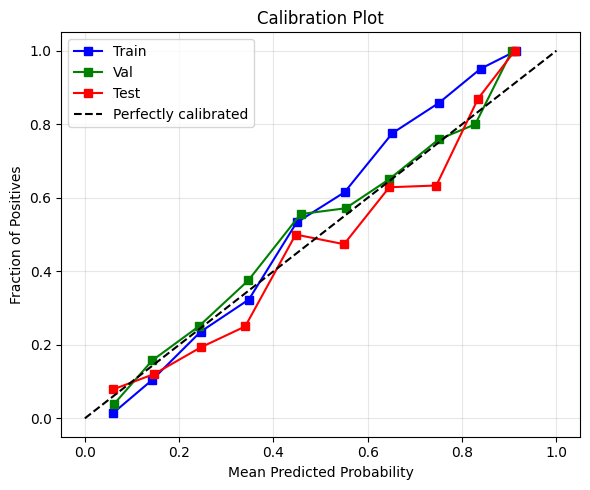

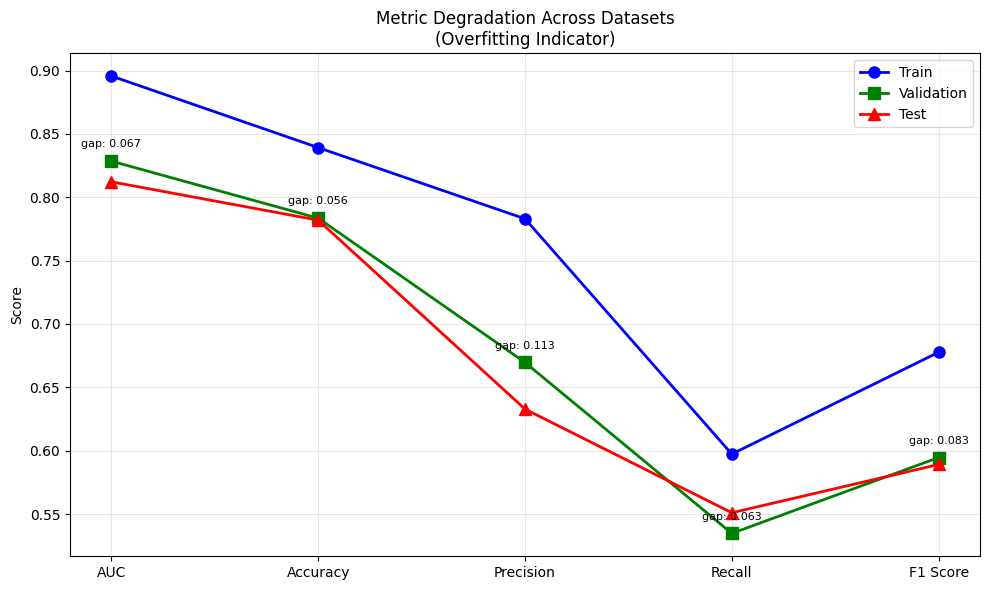


QUANTITATIVE OVERFITTING ASSESSMENT
Train-Val AUC Gap: 0.0672
Train-Test AUC Gap: 0.0835
Val-Test AUC Gap: 0.0163

OVERFITTING SEVERITY: MODERATE OVERFITTING
RECOMMENDATION: ⚠️  Consider adding more regularization
✓ Model shows consistent performance (Val-Test gap: 0.0163)

All overfitting analysis visualizations saved to model_store/xgboost_metrics/


In [9]:
# ADD THESE VISUALIZATIONS AFTER YOUR OVERFITTING ANALYSIS

# VISUALIZATION 6: Overfitting Analysis - Performance Gaps
plt.figure(figsize=(15, 5))

# Subplot 1: AUC progression across datasets
plt.subplot(1, 3, 1)
datasets = ['Train', 'Validation', 'Test']
auc_scores = [results['train']['AUC'], results['val']['AUC'], results['test']['AUC']]
colors = ['green', 'orange', 'red']
bars = plt.bar(datasets, auc_scores, color=colors, alpha=0.7)

# Add value labels on bars
for bar, score in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylabel('AUC Score')
plt.title('AUC Score Degradation\n(Train → Val → Test)')
plt.ylim(0.7, 0.95)
plt.grid(True, alpha=0.3)

# Subplot 2: Performance gaps visualization
plt.subplot(1, 3, 2)
metrics = ['AUC', 'Accuracy', 'F1 Score']
train_scores = [results['train'][metric] for metric in metrics]
val_scores = [results['val'][metric] for metric in metrics]
test_scores = [results['test'][metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.25

plt.bar(x - width, train_scores, width, label='Train', alpha=0.8)
plt.bar(x, val_scores, width, label='Validation', alpha=0.8)
plt.bar(x + width, test_scores, width, label='Test', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Across Datasets')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Gap analysis
plt.subplot(1, 3, 3)
gaps = {
    'Train-Val': results['train']['AUC'] - results['val']['AUC'],
    'Train-Test': results['train']['AUC'] - results['test']['AUC'],
    'Val-Test': results['val']['AUC'] - results['test']['AUC']
}

colors = ['red' if gap > 0.05 else 'orange' if gap > 0.02 else 'green' for gap in gaps.values()]
bars = plt.bar(gaps.keys(), gaps.values(), color=colors, alpha=0.7)

# Add threshold lines
plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Overfitting threshold (0.05)')
plt.axhline(y=0.02, color='orange', linestyle='--', alpha=0.7, label='Warning threshold (0.02)')

for bar, gap in zip(bars, gaps.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{gap:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylabel('AUC Gap')
plt.title('Performance Gaps Analysis')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_store/xgboost_metrics/overfitting_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# VISUALIZATION 7: Learning Curves (Proxy using prediction distributions)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Distribution of predicted probabilities
for name, color in zip(['train', 'val', 'test'], ['blue', 'green', 'red']):
    y_true, y_pred, y_prob = predictions[name]
    plt.hist(y_prob, bins=50, alpha=0.6, color=color, label=f'{name.capitalize()} (AUC: {results[name]["AUC"]:.3f})')

plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Calibration plot - how well calibrated are the probabilities?
from sklearn.calibration import calibration_curve

plt.figure(figsize=(6, 5))
for name, color in zip(['train', 'val', 'test'], ['blue', 'green', 'red']):
    y_true, y_pred, y_prob = predictions[name]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f'{name.capitalize()}', color=color)

plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_store/xgboost_metrics/probability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# VISUALIZATION 8: Detailed Metric Degradation
plt.figure(figsize=(10, 6))
metrics_detailed = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
train_metrics = [results['train'][m] for m in metrics_detailed]
val_metrics = [results['val'][m] for m in metrics_detailed]
test_metrics = [results['test'][m] for m in metrics_detailed]

x = np.arange(len(metrics_detailed))
plt.plot(x, train_metrics, 'o-', linewidth=2, markersize=8, label='Train', color='blue')
plt.plot(x, val_metrics, 's-', linewidth=2, markersize=8, label='Validation', color='green')
plt.plot(x, test_metrics, '^-', linewidth=2, markersize=8, label='Test', color='red')

plt.xticks(x, metrics_detailed)
plt.ylabel('Score')
plt.title('Metric Degradation Across Datasets\n(Overfitting Indicator)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add gap annotations
for i, metric in enumerate(metrics_detailed):
    gap = results['train'][metric] - results['val'][metric]
    plt.annotate(f'gap: {gap:.3f}', (i, val_metrics[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('model_store/xgboost_metrics/metric_degradation.png', dpi=300, bbox_inches='tight')
plt.show()

# Quantitative Overfitting Assessment
print("\n" + "="*60)
print("QUANTITATIVE OVERFITTING ASSESSMENT")
print("="*60)

train_val_gap = results['train']['AUC'] - results['val']['AUC']
train_test_gap = results['train']['AUC'] - results['test']['AUC']
val_test_gap = results['val']['AUC'] - results['test']['AUC']

print(f"Train-Val AUC Gap: {train_val_gap:.4f}")
print(f"Train-Test AUC Gap: {train_test_gap:.4f}") 
print(f"Val-Test AUC Gap: {val_test_gap:.4f}")

# Overfitting severity assessment
if train_val_gap > 0.1:
    severity = "SEVERE OVERFITTING"
    recommendation = "❌ Model needs significant regularization or more data"
elif train_val_gap > 0.05:
    severity = "MODERATE OVERFITTING"
    recommendation = "⚠️  Consider adding more regularization"
elif train_val_gap > 0.02:
    severity = "SLIGHT OVERFITTING" 
    recommendation = "ℹ️  Acceptable for complex models, monitor closely"
else:
    severity = "MINIMAL OVERFITTING"
    recommendation = "✅ Good generalization"

print(f"\nOVERFITTING SEVERITY: {severity}")
print(f"RECOMMENDATION: {recommendation}")

# Consistency check
consistency_gap = val_test_gap  # How much further does it drop from val to test
if consistency_gap < 0.02:
    print(f"✓ Model shows consistent performance (Val-Test gap: {consistency_gap:.4f})")
else:
    print(f"⚠️  Model shows some inconsistency (Val-Test gap: {consistency_gap:.4f})")

print(f"\nAll overfitting analysis visualizations saved to model_store/xgboost_metrics/")

### Select Best Model

In [10]:
# Load test AUCs from saved metrics
with open("model_store/logreg_metrics/logreg_test.json") as f:
    logreg_metrics = json.load(f)
with open("model_store/xgboost_metrics/xgboost_test.json") as f:
    xgb_metrics = json.load(f)

logreg_auc = logreg_metrics["AUC"]
xgb_auc = xgb_metrics["AUC"]

print("Validation AUCs:")
print(f"Logistic Regression: {logreg_auc}")
print(f"XGBoost: {xgb_auc}")

# Select best model
if xgb_auc > logreg_auc:
    best_model = joblib.load("model_store/xgboost_model.pkl")
    joblib.dump(best_model, "model_store/best_model.pkl")
    print("\nXGBoost selected as best model and saved as best_model.pkl")
else:
    print("\nLogistic Regression has better AUC but cannot be saved with joblib.")
    print("Use PySpark's .load() from model_store/logistic_model when needed.")

Validation AUCs:
Logistic Regression: 0.7798
XGBoost: 0.8122

XGBoost selected as best model and saved as best_model.pkl


### OOT

In [11]:
# Load best model (assumed XGBoost)
model = joblib.load("model_store/best_model.pkl")

# Helper to convert Spark → NumPy
def spark_df_to_numpy(df):
    pdf = df.select("loan_id", "features").toPandas()
    loan_ids = pdf["loan_id"].values
    X = np.vstack(pdf["features"].values)
    return loan_ids, X

# Loop over OOT months
oot_months = ["2024-03-01", "2024-04-01", "2024-05-01", "2024-06-01"]

for month in oot_months:
    df_month = scaled.filter(col("feature_snapshot_date") == month)
    loan_ids, X = spark_df_to_numpy(df_month)

    # Predict probabilities and labels
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)

    # Create output DataFrame
    pdf_out = {
        "loan_id": loan_ids,
        "prediction": y_pred,
        "probability": y_prob,
        "snapshot_date": [month] * len(loan_ids)
    }

    import pandas as pd
    spark_out = spark.createDataFrame(pd.DataFrame(pdf_out))

    # Save to gold datamart
    output_path = f"datamart/gold/predictions/predictions_oot_{month}.parquet"
    spark_out.write.mode("overwrite").parquet(output_path)
    print(f"Saved predictions for {month} to {output_path}")


Saved predictions for 2024-03-01 to datamart/gold/predictions/predictions_oot_2024-03-01.parquet
Saved predictions for 2024-04-01 to datamart/gold/predictions/predictions_oot_2024-04-01.parquet
Saved predictions for 2024-05-01 to datamart/gold/predictions/predictions_oot_2024-05-01.parquet
Saved predictions for 2024-06-01 to datamart/gold/predictions/predictions_oot_2024-06-01.parquet


### Monitor Stability (PSI)

In [12]:
# Reference = February 2024
ref_df = df.filter(col("feature_snapshot_date") == "2024-02-01").toPandas()

# Feature columns
non_features = ['Customer_ID', 'feature_snapshot_date', 'loan_id', 'label']
vec_cols = [c for c in ref_df.columns if c.endswith("_vec")]
feature_cols = [c for c in ref_df.columns if c not in non_features + vec_cols]

# PSI calculator
def calculate_psi(expected, actual, buckets=10):
    breakpoints = np.percentile(expected, np.linspace(0, 100, buckets + 1))
    expected_bins = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_bins = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    psi = np.sum((expected_bins - actual_bins) * np.log((expected_bins + 1e-6) / (actual_bins + 1e-6)))
    return round(psi, 4)

# Loop through OOT months
monitor_months = ["2024-03-01", "2024-04-01", "2024-05-01", "2024-06-01"]
psi_results = {}

for month in monitor_months:
    current_df = df.filter(col("feature_snapshot_date") == month).toPandas()
    psi_scores = {}

    for feat in feature_cols:
        try:
            psi_scores[feat] = calculate_psi(ref_df[feat].dropna(), current_df[feat].dropna())
        except Exception:
            psi_scores[feat] = None

    # Valid PSI scores only
    valid_psi = {k: v for k, v in psi_scores.items() if v is not None}
    avg_psi = round(np.mean(list(valid_psi.values())), 4)
    max_psi = round(max(valid_psi.values()), 4)

    # Alerting
    drifted_feats = [k for k, v in valid_psi.items() if v > 0.1]

    if avg_psi > 0.25:
        alert = "🔴 Investigate & consider retraining (high average PSI)"
        print(f"\n{month} — {alert}")
        print(f"Avg PSI: {avg_psi}")
        print("Drifted features (PSI > 0.1):", drifted_feats)

    elif avg_psi > 0.1:
        alert = "🟡 Monitor more closely (elevated average PSI)"
        print(f"\n{month} — {alert}")
        print(f"Avg PSI: {avg_psi}")
        print("Drifted features (PSI > 0.1):", drifted_feats)

    elif max_psi > 0.1:
        alert = "🟡 Monitor individual features (some drift)"
        print(f"\n{month} — {alert}")
        print(f"Max PSI: {max_psi}")
        print("Drifted features (PSI > 0.1):", drifted_feats)

    else:
        alert = "🟢 All clear (PSI stable)"
        print(f"\n{month} — {alert}")

    psi_results[month] = {
        "average_psi": avg_psi,
        "max_psi": max_psi,
        "drifted_features": drifted_feats,
        "alert": alert,
        "feature_psi": valid_psi
    }

# Save one JSON file per month
output_dir = "datamart/gold/monitoring/stability"
os.makedirs(output_dir, exist_ok=True)

for month, result in psi_results.items():
    filename = f"{output_dir}/stability_{month}.json"
    with open(filename, "w") as f:
        json.dump(result, f, indent=2)

print("\nStability (PSI) monitoring complete.")


2024-03-01 — 🟢 All clear (PSI stable)

2024-04-01 — 🟡 Monitor individual features (some drift)
Max PSI: 0.1159
Drifted features (PSI > 0.1): ['Num_of_Delayed_Payment']

2024-05-01 — 🟢 All clear (PSI stable)

2024-06-01 — 🟡 Monitor individual features (some drift)
Max PSI: 0.1111
Drifted features (PSI > 0.1): ['Num_of_Delayed_Payment']

Stability (PSI) monitoring complete.


### Monitor Performance (Metrics)

In [13]:
# Load baseline test metrics (from model_store)
with open("model_store/xgboost_metrics/xgboost_test.json") as f:
    baseline = json.load(f)

print("\nBaseline (Test Set / February 2024) Metrics")
print(baseline)

# Load labels
labels_df = pd.read_parquet("data/gold/combined_labeled.parquet")[["loan_id", "label"]]

# Evaluation function
def evaluate(y_true, y_pred, y_prob):
    return {
        "AUC":       round(roc_auc_score(y_true, y_prob), 4),
        "Accuracy":  round(accuracy_score(y_true, y_pred), 4),
        "Precision": round(precision_score(y_true, y_pred), 4),
        "Recall":    round(recall_score(y_true, y_pred), 4),
        "F1 Score":  round(f1_score(y_true, y_pred), 4)
    }

# Percentage change calculator
def percent_change(current, reference):
    return round(((current - reference) / reference) * 100, 2)

# Store results and alerts
results = {}

for month in ["2024-03-01", "2024-04-01", "2024-05-01", "2024-06-01"]:
    path = f"datamart/gold/predictions/predictions_oot_{month}.parquet"
    if os.path.exists(path):
        preds_df = pd.read_parquet(path)
        merged = preds_df.merge(labels_df, on="loan_id", how="left")

        if merged["label"].isnull().any():
            print(f"Warning: Missing labels in {month} predictions")

        y_true = merged["label"].values
        y_pred = merged["prediction"].values
        y_prob = merged["probability"].values

        # Evaluate metrics
        current_metrics = evaluate(y_true, y_pred, y_prob)
        print(f"\n=== {month} Metrics ===")
        print(current_metrics)

        # Compare against baseline
        changes = {k: percent_change(current_metrics[k], baseline[k]) for k in baseline}
        dropped = {k: v for k, v in changes.items() if v < -5}
        severe_drops = {k: v for k, v in changes.items() if v < -10}

        # Determine alert level
        if severe_drops:
            alert = "🔴 Significant performance drop"
        elif dropped:
            alert = "🟡 Moderate drop, monitor"
        else:
            alert = "🟢 All clear"

        print(f"% Change vs Test Set: {changes}")
        print(f"Alert: {alert}")
        if dropped:
            print("Metrics with drops:", dropped)

        # Store
        results[month] = {
            "metrics": current_metrics,
            "percentage_change": changes,
            "dropped_metrics": dropped,
            "alert": alert
        }

# Save one JSON file per month
output_dir = "datamart/gold/monitoring/performance"
os.makedirs(output_dir, exist_ok=True)

for month, result in results.items():
    filename = f"{output_dir}/performance_{month}.json"
    with open(filename, "w") as f:
        json.dump(result, f, indent=2)

print("\nPerformance monitoring complete.")


Baseline (Test Set / February 2024) Metrics
{'AUC': 0.8122, 'Accuracy': 0.7819, 'Precision': 0.6328, 'Recall': 0.551, 'F1 Score': 0.5891}

=== 2024-03-01 Metrics ===
{'AUC': 0.7939, 'Accuracy': 0.7671, 'Precision': 0.713, 'Recall': 0.4881, 'F1 Score': 0.5795}
% Change vs Test Set: {'AUC': -2.25, 'Accuracy': -1.89, 'Precision': 12.67, 'Recall': -11.42, 'F1 Score': -1.63}
Alert: 🔴 Significant performance drop
Metrics with drops: {'Recall': -11.42}

=== 2024-04-01 Metrics ===
{'AUC': 0.7821, 'Accuracy': 0.752, 'Precision': 0.566, 'Recall': 0.4255, 'F1 Score': 0.4858}
% Change vs Test Set: {'AUC': -3.71, 'Accuracy': -3.82, 'Precision': -10.56, 'Recall': -22.78, 'F1 Score': -17.54}
Alert: 🔴 Significant performance drop
Metrics with drops: {'Precision': -10.56, 'Recall': -22.78, 'F1 Score': -17.54}

=== 2024-05-01 Metrics ===
{'AUC': 0.8022, 'Accuracy': 0.7882, 'Precision': 0.7064, 'Recall': 0.5168, 'F1 Score': 0.5969}
% Change vs Test Set: {'AUC': -1.23, 'Accuracy': 0.81, 'Precision': 11.6

### Visualise Metrics

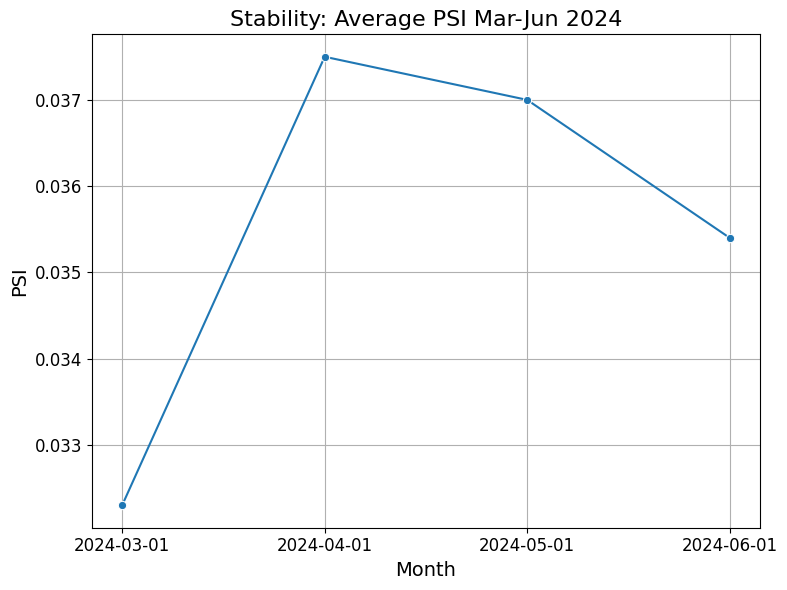

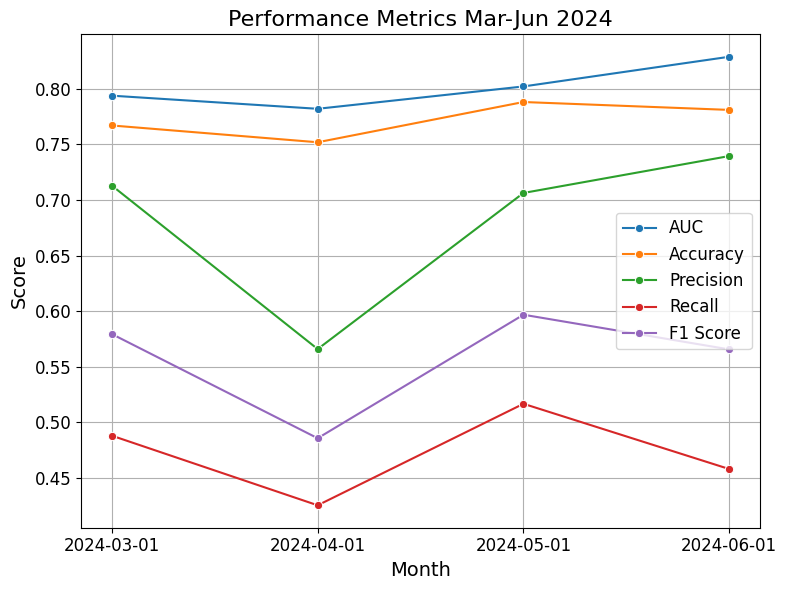

In [14]:
# Load monthly PSI JSONs
stability_dir = "datamart/gold/monitoring/stability"
psi_data = {}

for file in os.listdir(stability_dir):
    if file.endswith(".json"):
        month = file.replace("stability_", "").replace(".json", "")
        with open(os.path.join(stability_dir, file)) as f:
            psi_data[month] = json.load(f)

psi_df = pd.DataFrame.from_dict(
    {month: data["average_psi"] for month, data in psi_data.items()},
    orient='index', columns=["Average PSI"]
).sort_index()
psi_df.index.name = "Month"

# Load monthly performance JSONs
performance_dir = "datamart/gold/monitoring/performance"
perf_data = {}

for file in os.listdir(performance_dir):
    if file.endswith(".json"):
        month = file.replace("performance_", "").replace(".json", "")
        with open(os.path.join(performance_dir, file)) as f:
            perf_data[month] = json.load(f)

metrics = ["AUC", "Accuracy", "Precision", "Recall", "F1 Score"]
perf_df = pd.DataFrame.from_dict(
    {month: data["metrics"] for month, data in perf_data.items()},
    orient='index'
)[metrics].sort_index()
perf_df.index.name = "Month"

# Plotting
output_dir = "datamart/gold/monitoring"

# PSI Trend Plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=psi_df, x=psi_df.index, y="Average PSI", marker="o")
plt.title("Stability: Average PSI Mar-Jun 2024", fontsize=16)
plt.ylabel("PSI", fontsize=14)
plt.xlabel("Month", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "psi_trend_mar_to_jun.png"))
plt.show()

# Performance Metrics Plot
plt.figure(figsize=(8, 6))
for metric in metrics:
    sns.lineplot(data=perf_df, x=perf_df.index, y=metric, marker="o", label=metric)
plt.title("Performance Metrics Mar-Jun 2024", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Month", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "performance_trends_mar_to_jun.png"))
plt.show()

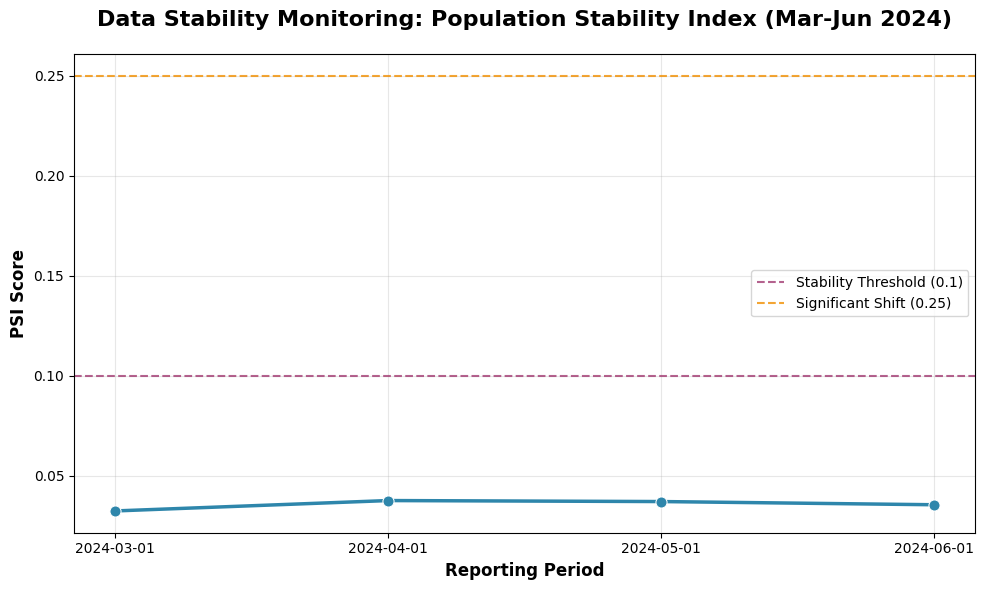

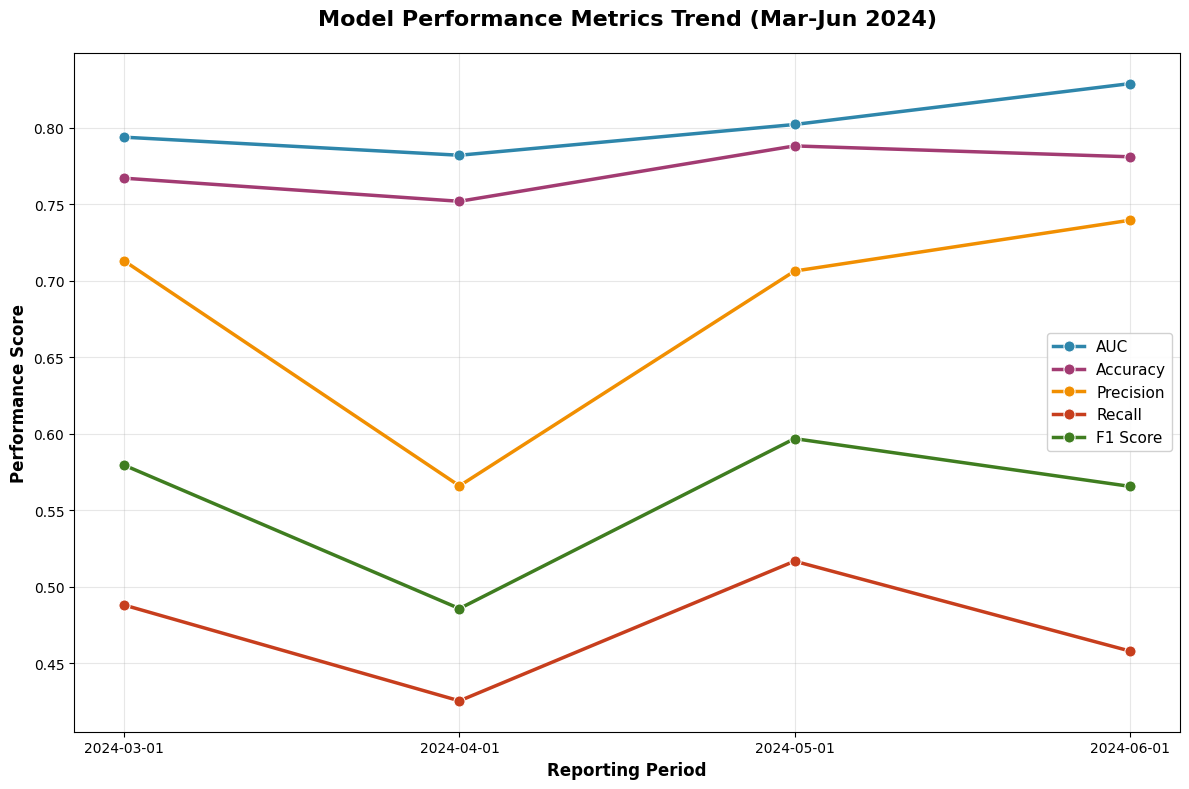

✅ Business Intelligence Dashboard Generated:
   📊 Data Stability Report: business_psi_trend.png
   📈 Performance Dashboard: business_performance_dashboard.png


In [15]:
# =============================================================================
# BUSINESS INTELLIGENCE: MODEL PERFORMANCE & STABILITY DASHBOARD
# =============================================================================

# Load monthly PSI monitoring data
stability_dir = "datamart/gold/monitoring/stability"
psi_data = {}

for file in os.listdir(stability_dir):
    if file.endswith(".json"):
        month = file.replace("stability_", "").replace(".json", "")
        with open(os.path.join(stability_dir, file)) as f:
            psi_data[month] = json.load(f)

# Create PSI trend dataframe
psi_df = pd.DataFrame.from_dict(
    {month: data["average_psi"] for month, data in psi_data.items()},
    orient='index', columns=["PSI Score"]
).sort_index()
psi_df.index.name = "Period"

# Load monthly performance metrics
performance_dir = "datamart/gold/monitoring/performance"
perf_data = {}

for file in os.listdir(performance_dir):
    if file.endswith(".json"):
        month = file.replace("performance_", "").replace(".json", "")
        with open(os.path.join(performance_dir, file)) as f:
            perf_data[month] = json.load(f)

# Create performance metrics dataframe
metrics = ["AUC", "Accuracy", "Precision", "Recall", "F1 Score"]
perf_df = pd.DataFrame.from_dict(
    {month: data["metrics"] for month, data in perf_data.items()},
    orient='index'
)[metrics].sort_index()
perf_df.index.name = "Period"

# =============================================================================
# PROFESSIONAL BUSINESS VISUALIZATIONS
# =============================================================================
output_dir = "datamart/gold/monitoring"

# 1. DATA STABILITY TREND (PSI)
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(111)
sns.lineplot(data=psi_df, x=psi_df.index, y="PSI Score", marker="o", 
             linewidth=2.5, markersize=8, color="#2E86AB")
plt.title("Data Stability Monitoring: Population Stability Index (Mar-Jun 2024)", 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel("PSI Score", fontsize=12, fontweight='bold')
plt.xlabel("Reporting Period", fontsize=12, fontweight='bold')

# Add threshold lines and styling
plt.axhline(y=0.1, color='#A23B72', linestyle='--', alpha=0.8, label='Stability Threshold (0.1)')
plt.axhline(y=0.25, color='#F18F01', linestyle='--', alpha=0.8, label='Significant Shift (0.25)')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "business_psi_trend.png"), dpi=300, bbox_inches='tight')
plt.show()

# 2. MODEL PERFORMANCE DASHBOARD
plt.figure(figsize=(12, 8))
ax2 = plt.subplot(111)

# Professional color palette
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3F7D20']

for i, metric in enumerate(metrics):
    sns.lineplot(data=perf_df, x=perf_df.index, y=metric, marker="o", 
                 linewidth=2.5, markersize=8, color=colors[i], label=metric)

plt.title("Model Performance Metrics Trend (Mar-Jun 2024)", 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Performance Score", fontsize=12, fontweight='bold')
plt.xlabel("Reporting Period", fontsize=12, fontweight='bold')
plt.legend(fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "business_performance_dashboard.png"), 
            dpi=300, bbox_inches='tight')
plt.show()

print("✅ Business Intelligence Dashboard Generated:")
print("   📊 Data Stability Report: business_psi_trend.png")
print("   📈 Performance Dashboard: business_performance_dashboard.png")

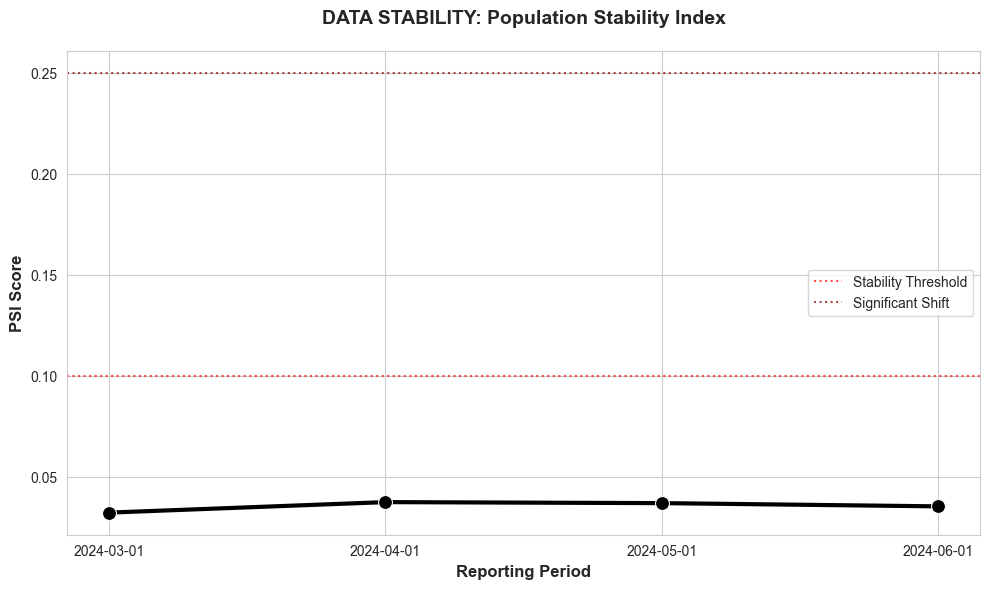

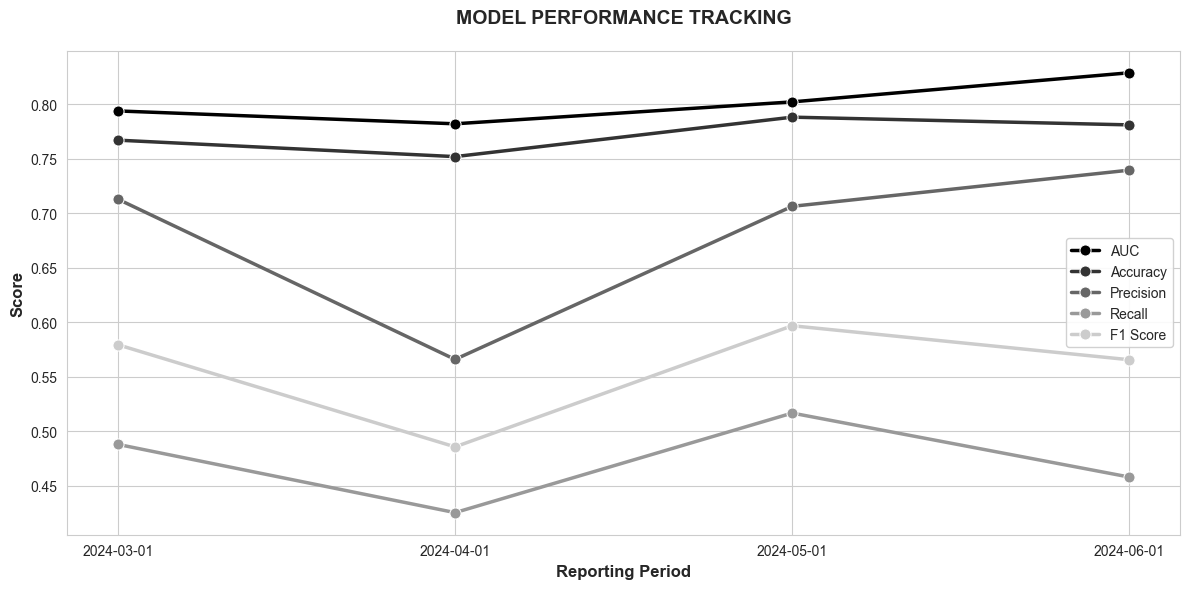

✅ Executive Dashboard Generated
   📊 Stability Report: executive_psi_trend.png
   📈 Performance Track: executive_performance_dashboard.png


In [16]:
# =============================================================================
# EXECUTIVE DASHBOARD: MODEL PERFORMANCE & STABILITY
# =============================================================================

# Load monthly PSI monitoring data
stability_dir = "datamart/gold/monitoring/stability"
psi_data = {}

for file in os.listdir(stability_dir):
    if file.endswith(".json"):
        month = file.replace("stability_", "").replace(".json", "")
        with open(os.path.join(stability_dir, file)) as f:
            psi_data[month] = json.load(f)

# Create PSI trend dataframe
psi_df = pd.DataFrame.from_dict(
    {month: data["average_psi"] for month, data in psi_data.items()},
    orient='index', columns=["PSI Score"]
).sort_index()
psi_df.index.name = "Period"

# Load monthly performance metrics
performance_dir = "datamart/gold/monitoring/performance"
perf_data = {}

for file in os.listdir(performance_dir):
    if file.endswith(".json"):
        month = file.replace("performance_", "").replace(".json", "")
        with open(os.path.join(performance_dir, file)) as f:
            perf_data[month] = json.load(f)

# Create performance metrics dataframe
metrics = ["AUC", "Accuracy", "Precision", "Recall", "F1 Score"]
perf_df = pd.DataFrame.from_dict(
    {month: data["metrics"] for month, data in perf_data.items()},
    orient='index'
)[metrics].sort_index()
perf_df.index.name = "Period"

# =============================================================================
# EXECUTIVE-STYLE VISUALIZATIONS
# =============================================================================
output_dir = "datamart/gold/monitoring"

# 1. DATA STABILITY TREND - BLACK THEME
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax1 = plt.subplot(111)
sns.lineplot(data=psi_df, x=psi_df.index, y="PSI Score", marker="o", 
             linewidth=3, markersize=10, color='black')
plt.title("DATA STABILITY: Population Stability Index", 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel("PSI Score", fontsize=12, fontweight='bold')
plt.xlabel("Reporting Period", fontsize=12, fontweight='bold')

# Clean, minimal threshold lines
plt.axhline(y=0.1, color='red', linestyle=':', alpha=0.7, label='Stability Threshold')
plt.axhline(y=0.25, color='darkred', linestyle=':', alpha=0.7, label='Significant Shift')
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "executive_psi_trend.png"), dpi=300, bbox_inches='tight')
plt.show()

# 2. PERFORMANCE DASHBOARD - BLACK THEME
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Black and gray color scheme
colors = ['black', '#333333', '#666666', '#999999', '#CCCCCC']

for i, metric in enumerate(metrics):
    sns.lineplot(data=perf_df, x=perf_df.index, y=metric, marker="o", 
                 linewidth=2.5, markersize=8, color=colors[i], label=metric)

plt.title("MODEL PERFORMANCE TRACKING", fontsize=14, fontweight='bold', pad=20)
plt.ylabel("Score", fontsize=12, fontweight='bold')
plt.xlabel("Reporting Period", fontsize=12, fontweight='bold')
plt.legend(fontsize=10, framealpha=0.9)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "executive_performance_dashboard.png"), 
            dpi=300, bbox_inches='tight')
plt.show()

print("✅ Executive Dashboard Generated")
print("   📊 Stability Report: executive_psi_trend.png")
print("   📈 Performance Track: executive_performance_dashboard.png")